In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# input files
QCEW_FILEPATH = '../data/QCEW_2000-2018_cleaned_naics_sectors.csv'
LAP_ACRES_FILEPATH = '../data/LAP_landuse_acres.csv'

# constants
WOH_COUNTIES = ['Delaware', 'Greene', 'Schoharie', 'Sullivan', 'Ulster']
EOH_COUNTIES = ['Dutchess', 'Putnam', 'Westchester']
METRICS = ['Real Total Salary', 'Real Average Salary', 'Average Employment', 'Establishments']
TOTAL_INDUSTRIES = ['Total, All Industries', 'Total, All Private', 'Total, All Government']
LANDUSE_TYPES = ['Agricultural Land', 'Forest Land', 'Urban/Built-up Land', 'Others']
       

In [2]:
qcew = pd.read_csv(QCEW_FILEPATH, index_col=0)
qcew.head()

,NAICS,NAICS Title,Year,Establishments,Average Employment,Total Wage,Annual Average Salary,CPI,Real Average Salary,Real Total Salary
County,,,,,,,,,,
Albany,0,"Total, All Industries",2018,10252,233679,1.361919e+10,58282.0,273.641,58282.0,1.361919e+10
Albany,1,"Total, All Private",2018,9813,172969,9.545942e+09,55189.0,273.641,55189.0,9.545942e+09
Albany,11,"Agriculture, Forestry, Fishing and Hunting",2018,17,235,7.986065e+06,33983.0,273.641,33983.0,7.986065e+06
Albany,22,Utilities,2018,11,520,6.750030e+07,129808.0,273.641,129808.0,6.750030e+07
Albany,23,Construction,2018,696,7554,5.878178e+08,77815.0,273.641,77815.0,5.878178e+08


In [3]:
# load LAP Acres
lap_acres = pd.read_csv(LAP_ACRES_FILEPATH, index_col=0)
lap_acres.head()

,FID_LAP,FID_LU,SWIS_SBL,PROP_ID,landuse_code,landuse_acres,property_acres,acquisition_method,subprogram,real_estate_type,county,town,closing_date,side_of_hudson,parcel_status,landuse,year
0,643,106257,5.14E+25,7,3000,4.607891,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
1,643,106333,5.14E+25,7,1210,0.096011,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Others,1999
2,643,106334,5.14E+25,7,1210,0.008777,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Others,1999
3,643,106818,5.14E+25,7,4200,2.485314,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999
4,643,106821,5.14E+25,7,4200,0.494484,18.090218,LAP,City,Fee,Ulster,Olive,1999-09-08,West,Complete,Forest Land,1999


In [4]:
# years avail for our datasets
print('years avail for qcew:', qcew.Year.min(), '-', qcew.Year.max())
print('years avail for lap:', lap_acres.year.min(), '-', lap_acres.year.max())
common_years = set(qcew.Year).intersection(set(lap_acres.index))
print('common years:', common_years)

years avail for qcew: 2000 - 2018
years avail for lap: 1997 - 2020
common years: {2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018}


In [5]:
# truncate datasets to common years ie 2000-2018
lap_acres = lap_acres[lap_acres.year.isin(common_years)]
qcew = qcew[qcew.Year.isin(common_years)]

In [6]:
lap_acres.landuse.unique()

array(['Forest Land', 'Others', 'Urban/Built-up Land',
       'Agricultural Land'], dtype=object)

# Output as json (for viz)

In [7]:
# WOH: industries x metric x counties x landuse
correlations = {}
for metric in METRICS:
    correlations[metric] = {}
    for landuse_type in LANDUSE_TYPES:
        correlations[metric][landuse_type] = {}
        for county in WOH_COUNTIES: 
            subset = qcew[qcew.index==county].pivot(index='Year',
                                                         columns='NAICS Title',
                                                         values=metric)
            subset.dropna(axis='columns', how='any', inplace=True)

            subset['landuse_acres'] = lap_acres[(lap_acres.landuse==landuse_type) 
                                                & (lap_acres.county==county)]\
                                        .pivot_table(index='year', 
                                                     values='landuse_acres', 
                                                     aggfunc='sum', 
                                                     fill_value=0)
            correlations[metric][landuse_type][county] = subset.corr().iloc[-1, :-1].to_dict() # industry: corr val

In [8]:
import json
with open('../output/woh_corr_4.json', 'w') as f:
    json.dump(correlations, f)

# Viz

In [9]:
def plot_corr(landuse_type, metric):
    correlations = {}
    for industry in np.setdiff1d(qcew['NAICS Title'].unique() , TOTAL_INDUSTRIES):
        qcew_subset = qcew[(qcew['NAICS Title']==industry) & qcew.index.isin(WOH_COUNTIES)]\
                        .pivot_table(index='Year', 
                                     columns='County', 
                                     values=metric)
        if qcew_subset.isnull().any().any(): continue

        lap_subset = lap_acres[lap_acres.landuse==landuse_type]\
                        .pivot_table(index='year', 
                                     columns='county', 
                                     values='landuse_acres', 
                                     aggfunc='sum', 
                                     fill_value=0)

        correlations[industry] = qcew_subset.corrwith(lap_subset).to_dict()

    correlations = pd.DataFrame(correlations)
    # plot
    _, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(correlations.transpose(), 
                center=0, vmin=-1, vmax=1, 
                cmap=sns.diverging_palette(10, 145, sep=40, n=10),
                annot=True,
                ax=ax)
    ax.set_title('Correlation between\nLanduse (acres acquired): %s\nEconomic Metric: %s'%(landuse_type, metric))


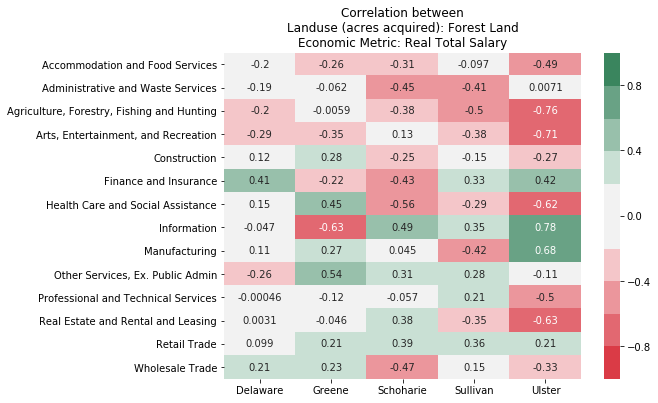

In [11]:
plot_corr(landuse_type='Forest Land', metric='Real Total Salary')

In [103]:
requests = [{'metric': 'Real Average Salary',
             'county': 'Greene',
             'industry': 'Other Services, Ex. Public Admin'
            },
            {'metric': 'Real Average Salary',
             'county': 'Schoharie',
             'industry': 'Agriculture, Forestry, Fishing and Hunting'
            },
            {'metric': 'Real Average Salary',
             'county': 'Ulster',
             'industry': 'Agriculture, Forestry, Fishing and Hunting'
            },
            {'metric': 'Real Average Salary',
             'county': 'Greene',
             'industry': 'Arts, Entertainment, and Recreation'
            },
            {'metric': 'Real Average Salary',
             'county': 'Schoharie',
             'industry': 'Administrative and Waste Services'
            },
            {'metric': 'Average Employment',
             'county': 'Ulster',
             'industry': 'Information'
            },
            {'metric': 'Average Employment',
             'county': 'Ulster',
             'industry': 'Arts, Entertainment, and Recreation'
            },
            {'metric': 'Establishments',
             'county': 'Ulster',
             'industry': 'Manufacturing'
            },
            {'metric': 'Establishments',
             'county': 'Ulster',
             'industry': 'Professional and Technical Services'
            },
            {'metric': 'Establishments',
             'county': 'Greene',
             'industry': 'Retail Trade'
            }]

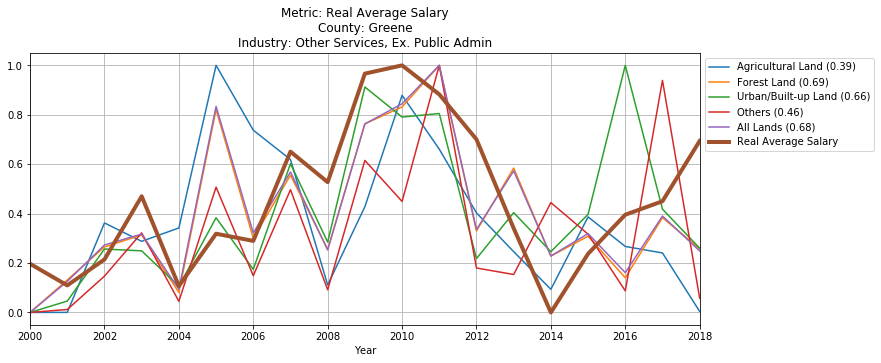

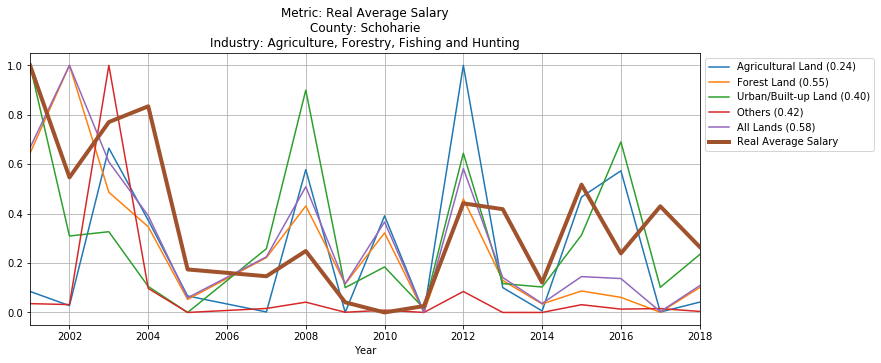

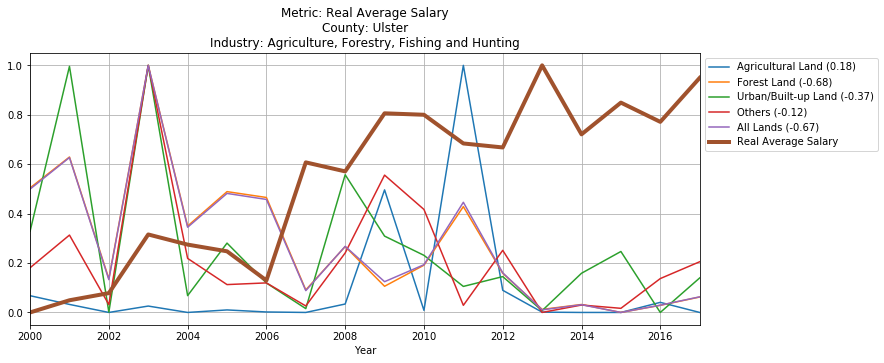

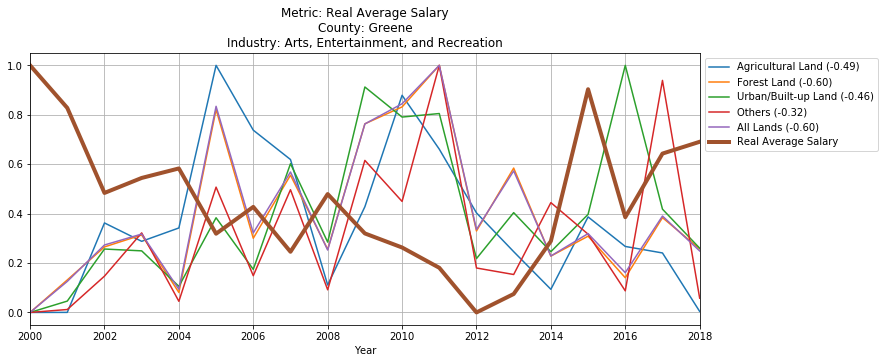

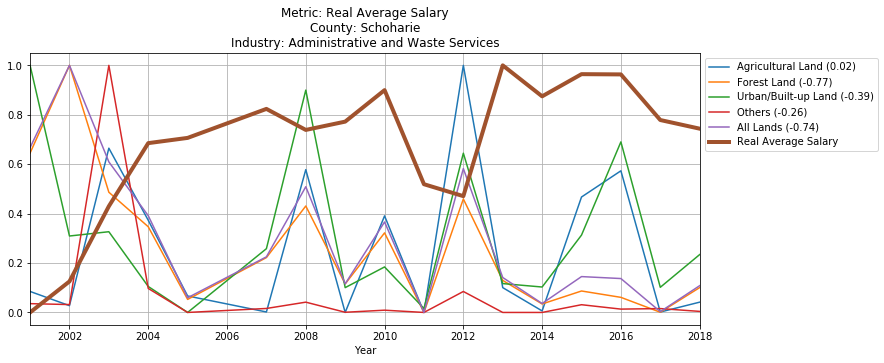

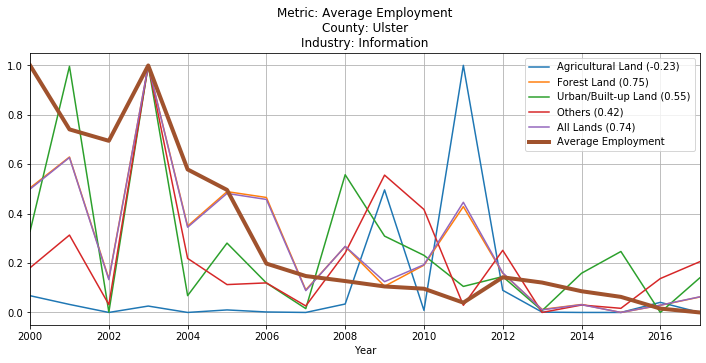

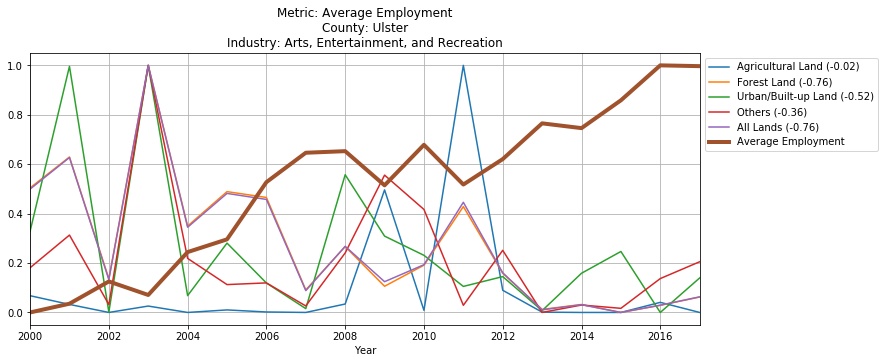

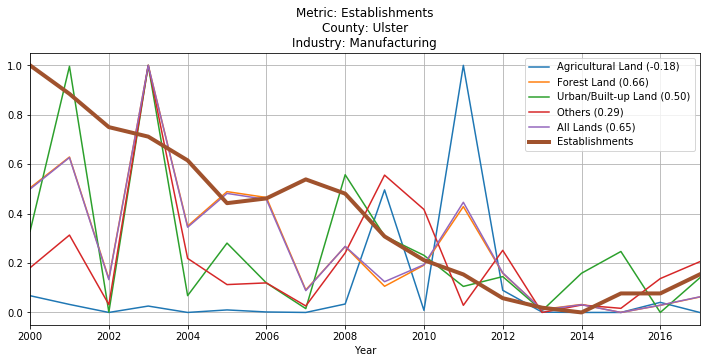

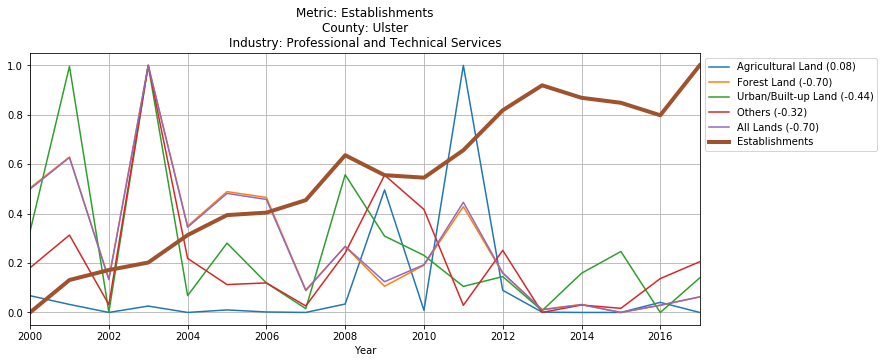

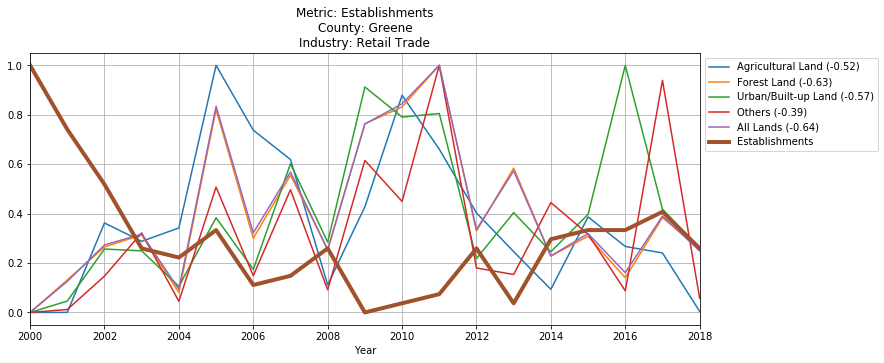

In [118]:
# plot trends for specific correlations
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

scaler = MinMaxScaler()

for req in requests:
    metric = req['metric']
    county = req['county']
    industry = req['industry']

    ### data wrangling
    # lap data
    subset = lap_acres[lap_acres.county==county]\
                    .pivot_table(index='year', 
                                 columns='landuse', 
                                 values='landuse_acres', 
                                 aggfunc='sum', 
                                 fill_value=0)\
                    [LANDUSE_TYPES]
    subset['All Lands'] = subset.sum(axis=1)

    # add economic data to it
    subset = subset.join(qcew[(qcew.index==county) 
                       & (qcew['NAICS Title']==industry)]\
                    .set_index('Year')
                    [[metric]])
    # min max scale the data
    subset = pd.DataFrame(scaler.fit_transform(subset), 
                          columns=subset.columns,
                          index=subset.index)
    labels = ['%s (%.2f)'%pair for pair in subset.corr().iloc[-1, :-1].items()]
    labels.append(metric)
    ### plotting
    # plot lap acres
    title = 'Metric: %s\nCounty: %s\nIndustry: %s'%(metric, county, industry)
    ax = subset.iloc[:, :-1].plot(figsize=(12,5),
                                  title=title)
    # plot economic metric
    subset[metric].plot(ax=ax, linewidth=4, color='sienna')

    plt.legend(labels=labels,
               bbox_to_anchor=(1,1))
    plt.xlabel('Year')
    plt.grid(True)

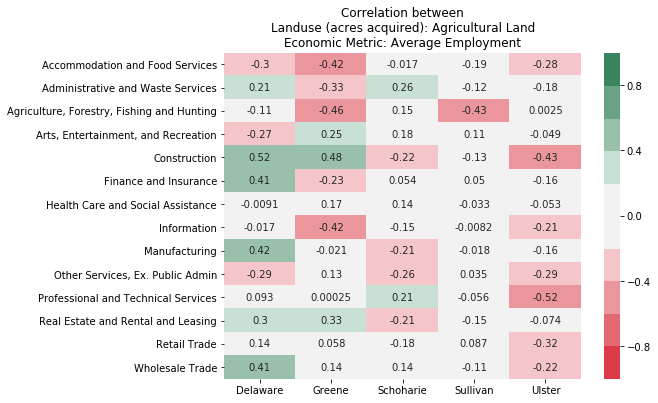

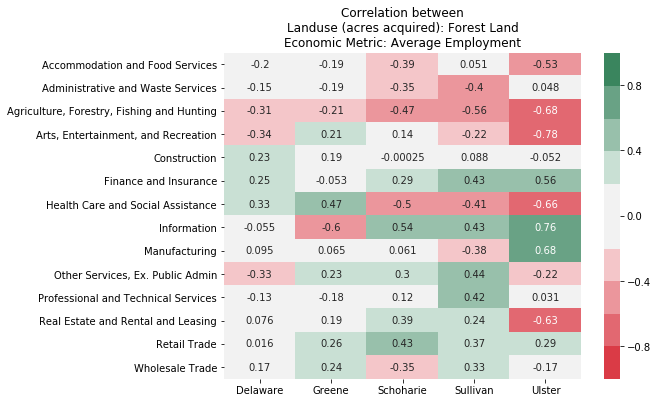

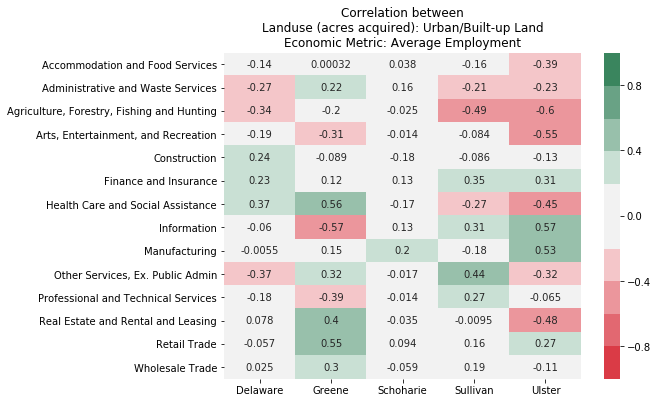

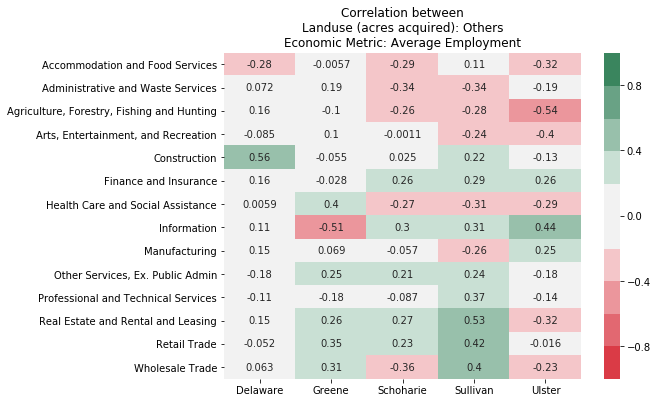

In [21]:
for landuse_type in LANDUSE_TYPES:
    plot_corr(landuse_type=landuse_type, metric='Average Employment')

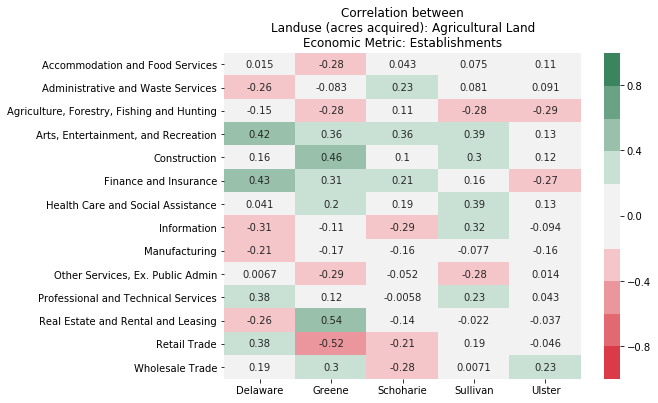

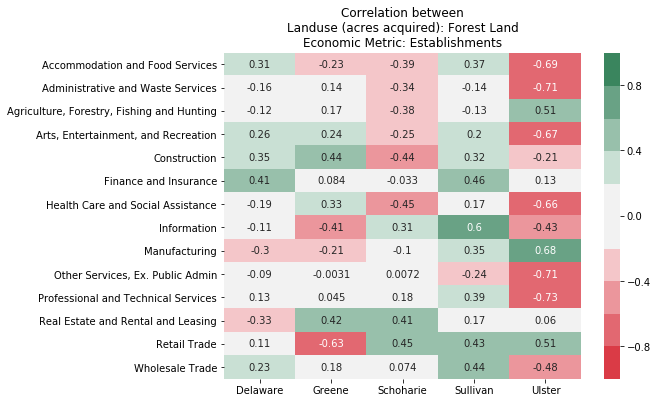

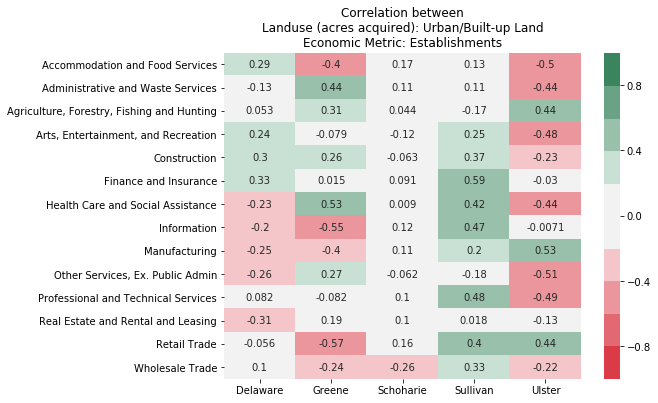

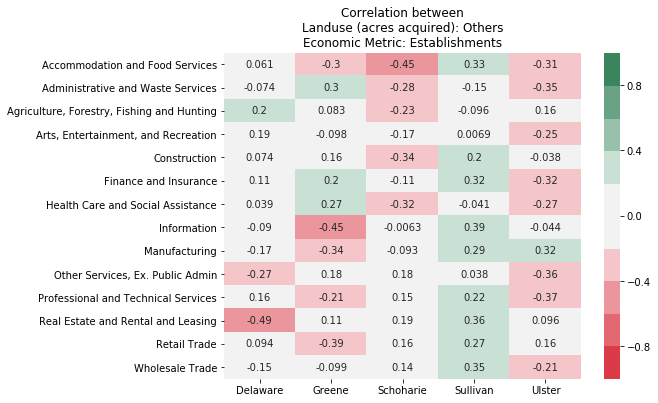

In [22]:
for landuse_type in LANDUSE_TYPES:
    plot_corr(landuse_type=landuse_type, metric='Establishments')